In [1]:
!pip install -U tensorflow_hub
!pip install tf-nightly-gpu

Requirement already up-to-date: tensorflow_hub in /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages (0.5.0)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf
tf.enable_eager_execution()

W0727 09:11:44.043738 139751577950016 module_wrapper.py:136] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.



In [3]:
import tensorflow_hub as hub

from tensorflow.keras import layers

In [4]:
IMAGE_SHAPE = (224, 224)

In [5]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [6]:
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

W0727 09:11:49.686773 139751577950016 module_wrapper.py:136] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [7]:
data_root = "/home/badc0ded/notebooks/data/train"

The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.

In [8]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 11390 images belonging to 2 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [9]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [10]:
result_batch = classifier.predict(image_batch)
result_batch.shape
result_batch[0]
len(result_batch[0])

1001

In [11]:
import numpy as np
import PIL.Image as Image

In [15]:
imagenet_labels = np.array(['boat', 'nature'])
imagenet_labels

array(['boat', 'nature'], dtype='<U6')

In [16]:
#predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
#predicted_class_names

Now check how these predictions line up with the images:

In [ ]:
#plt.figure(figsize=(10,9))
#plt.subplots_adjust(hspace=0.5)
#for n in range(30):
#  plt.subplot(6,5,n+1)
#  plt.imshow(image_batch[n])
#  plt.title(predicted_class_names[n])
#  plt.axis('off')
#_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [TensorFlow 1.x image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector) from tfhub.dev will work here.

In [17]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

Create the module, and check the expected image size:

In [18]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

The feature extractor returns a 1280-element vector for each image.

In [19]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [20]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [21]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
predictions = model(image_batch)

In [23]:
predictions.shape

TensorShape([Dimension(32), Dimension(2)])

### Train the model

Use compile to configure the training process:

In [24]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [25]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [26]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

W0727 09:22:27.547990 139751577950016 deprecation.py:323] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2


W0727 09:22:27.683749 139751577950016 deprecation.py:323] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


356/356 [==============================] - 346s 973ms/step - loss: 0.0159 - acc: 1.0000
Epoch 2/2
356/356 [==============================] - 334s 937ms/step - loss: 0.0025 - acc: 1.0000


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

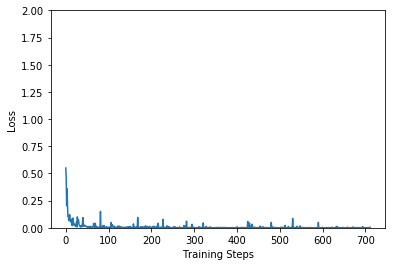

In [27]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

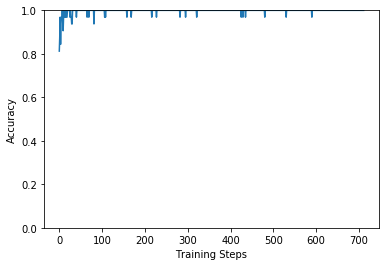

In [28]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [29]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Boat', 'Nature'], dtype='<U6')

Run the image batch through the model and convert the indices to class names.

In [30]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [31]:
label_id = np.argmax(label_batch, axis=-1)

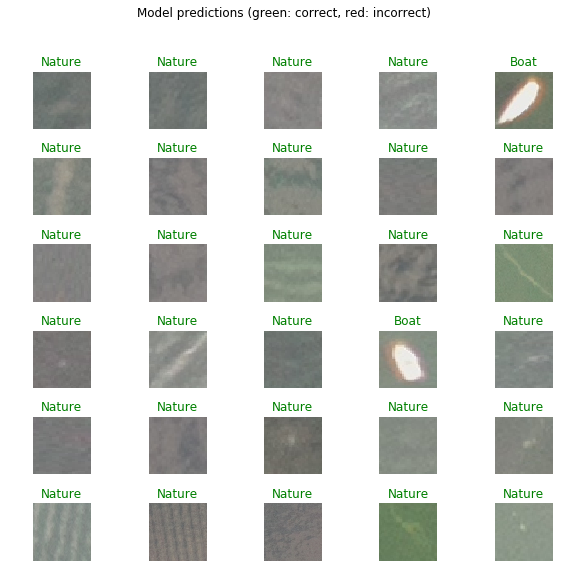

In [32]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export your model

Now that you've trained the model, export it as a saved model:

In [33]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

W0727 09:38:00.393948 139751577950016 deprecation.py:323] From <ipython-input-33-47b3eb0809fe>:5: export_saved_model (from tensorflow.python.keras.saving.saved_model_experimental) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.
W0727 09:38:02.637299 139751577950016 deprecation.py:506] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1784: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0727 09:38:05.162938 139751577950016 deprecation.py:506] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from te

'/tmp/saved_models/1564220280'

Now confirm that we can reload it, and it still gives the same results:

In [34]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

W0727 09:38:33.013174 139751577950016 deprecation.py:323] From <ipython-input-34-e6826f3d5aba>:1: load_from_saved_model (from tensorflow.python.keras.saving.saved_model_experimental) is deprecated and will be removed in a future version.
Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


In [35]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [36]:
abs(reloaded_result_batch - result_batch).max()

0.0

This saved model can loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).

